In [3]:
from pathlib import Path
from Bio.PDB import PDBList, PDBParser
import os
from tqdm import tqdm
import warnings
import pandas as pd
from Bio import SeqIO
from dotenv import load_dotenv
import os
import requests
import time
import json
from Bio.PDB.ic_rebuild import structure_rebuild_test
import numpy as np
import sys
import seaborn as sns

load_dotenv()

True

In [4]:
WINDOW_SIZE = 5
PDBMINE_URL = os.getenv("PDBMINE_URL")
casp_protein_id = 'T1024'
pdb_code = '6t1z'

In [5]:
amino_acid_codes = {
    "ALA": "A",
    "ARG": "R",
    "ASN": "N",
    "ASP": "D",
    "CYS": "C",
    "GLN": "Q",
    "GLU": "E",
    "GLY": "G",
    "HIS": "H",
    "ILE": "I",
    "LEU": "L",
    "LYS": "K",
    "MET": "M",
    "PHE": "F",
    "PRO": "P",
    "SER": "S",
    "THR": "T",
    "TRP": "W",
    "TYR": "Y",
    "VAL": "V"
}

In [7]:
# Get X-ray pdb
pdbl = PDBList()
parser = PDBParser()
xray_fn = pdbl.retrieve_pdb_file(pdb_code, pdir='pdb', file_format='pdb', obsolete=False)

# Get CASP predictions
predictions_url = f'https://predictioncenter.org/download_area/CASP14/predictions/regular/{casp_protein_id}.tar.gz'
predictions_dir = Path(f'./casp-predictions/')
predictions_dir.mkdir(exist_ok=True)
# os.system(f'wget -O {predictions_dir}/{casp_protein_id}.tar.gz {predictions_url}')
# os.system(f'tar -xvf {predictions_dir}/{casp_protein_id}.tar.gz -C {predictions_dir}')

# Get CASP results
results_url = 'https://predictioncenter.org/download_area/CASP14/results/tables/casp14.res_tables.T.tar.gz'
results_dir = Path('casp-results')
results_dir.mkdir(exist_ok=True)
# os.system(f'wget -O {results_dir / "casp14.res_tables.T.tar.gz"} {results_url}')
# os.system(f'tar -xvf {results_dir / "casp14.res_tables.T.tar.gz"} -C {results_dir}')
results_file = results_dir / f'{casp_protein_id}.txt'

Structure exists: 'pdb/pdb6t1z.ent' 


In [8]:
# Get structures
xray = parser.get_structure(pdb_code, xray_fn)

predicted_structures = []
for prediction_pdb in tqdm((predictions_dir / casp_protein_id).iterdir()):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        predicted_structures.append(parser.get_structure(prediction_pdb.name, prediction_pdb))

512it [00:18, 27.07it/s]


In [9]:
results = pd.read_csv(results_file, delim_whitespace=True)
results = results[results.columns[1:]]

In [8]:
# Get Phi-Psi distribution from PDBMine
for record in SeqIO.parse(xray_fn, "pdb-seqres"):
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    print(record)
residue_chain = str(record.seq)
code_length = 1
broken_chains = []
# break into sections of length 100
for i in range(0, len(residue_chain), 100-WINDOW_SIZE+1):
    broken_chains.append(residue_chain[i:i+100])

matches = {}
for chain in tqdm(broken_chains):
    if len(chain) < WINDOW_SIZE:
        continue
    response = requests.post(
        PDBMINE_URL + '/v1/api/query',
        json={
            "residueChain": chain,
            "codeLength": code_length,
            "windowSize": WINDOW_SIZE
        }
    )
    assert(response.ok)
    print(response.json())
    query_id = response.json().get('queryID')
    assert(query_id)

    time.sleep(15)
    while(True):
        response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
        if response.ok:
            matchesi = response.json()['frames']
            break
        else:
            print('Waiting')
            time.sleep(15)
    print('Received matches')
    matches.update(matchesi)
json.dump(matches, open('matches.json', 'w'))

Record id 6T1Z:A, chain A
ID: 6T1Z:A
Name: 6T1Z:A
Description: UNP:Q48658 Q48658_9LACT
Database cross-references: UNP:Q48658, UNP:Q48658_9LACT
Number of features: 0
/chain=A
/molecule_type=protein
Seq('GKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAV...FQG')


  0%|          | 0/5 [00:00<?, ?it/s]

{'status': 'Running', 'queryID': '3c4aa22e-f2ae-11ee-8b85-0242ac110002'}
Waiting
Waiting
Waiting


 20%|██        | 1/5 [01:00<04:01, 60.27s/it]

Received matches
{'status': 'Running', 'queryID': '603654f6-f2ae-11ee-8b85-0242ac110002'}
Waiting
Waiting
Waiting


 40%|████      | 2/5 [02:00<03:00, 60.27s/it]

Received matches
{'status': 'Running', 'queryID': '84226ce8-f2ae-11ee-8b85-0242ac110002'}
Waiting
Waiting


 60%|██████    | 3/5 [02:45<01:46, 53.36s/it]

Received matches
{'status': 'Running', 'queryID': '9f0be705-f2ae-11ee-8b85-0242ac110002'}
Waiting
Waiting
Waiting


 80%|████████  | 4/5 [03:45<00:56, 56.10s/it]

Received matches
{'status': 'Running', 'queryID': 'c2fc3594-f2ae-11ee-8b85-0242ac110002'}


100%|██████████| 5/5 [04:01<00:00, 48.22s/it]

Received matches


## Collect by Residue

In [38]:
# Get phi-psi by residue
phi_psi_mined_ = []
for seq_win,v in tqdm(matches.items()):
    seq = seq_win[4:]
    for protein,seq_matches in v.items():
        # get phi and psi of each residue in window for each match
        protein_id, chain = protein.split('_')
        if protein_id == pdb_code:
            continue
        for seq_match in seq_matches:
            for i,match in enumerate(seq_match):
                res, phi, psi = match['residueName'], match['phi'], match['psi']
                # phi_psi_mined.loc[len(phi_psi_mined)] = [res, phi, psi, seq, i, chain, protein_id]
                phi_psi_mined_.append([res, phi, psi, seq, i, chain, protein_id])
phi_psi_mined = pd.DataFrame(phi_psi_mined_, columns=['res','phi', 'psi', 'seq', 'idx_in_seq', 'chain', 'protein_id'])
phi_psi_mined.to_csv('phi_psi_mined.csv', index=False)

100%|██████████| 407/407 [00:00<00:00, 3214.24it/s]


In [ ]:
# Get phi_psi's of each prediction

def get_phi_psi(protein_id, protein, window_size):
    phi_psi = pd.DataFrame(columns=['res','phi', 'psi', 'seq', 'idx_in_seq', 'chain', 'pos_in_chain', 'protein_id'])
    chain = list(prediction[0].get_chains())[0]
    chain.atom_to_internal_coordinates(verbose=True)
    resultDict = structure_rebuild_test(chain)
    if not resultDict['pass']:
        print(f"Failed {protein_id} {chain.id}")
        raise Exception('Failed to rebuild')
    residues = list(chain.get_residues())
    j = 0
    seq = ''
    for i in range(len(residues)):
        # Convert 3 char codes to 1 char codes
        if j == 0 and i+window_size < len(residues):
            seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i:i+window_size]])
        key = amino_acid_codes.get(residues[i].resname, 'X')
        if not residues[i].internal_coord:
            psi,phi = np.nan, np.nan
        else:
            psi = residues[i].internal_coord.get_angle("psi")
            phi = residues[i].internal_coord.get_angle("phi")
        psi = psi if psi else np.nan
        phi = phi if phi else np.nan
        phi_psi.loc[len(phi_psi)] = [key, phi, psi, seq, j, chain.id, residues[i].get_full_id()[3][1], protein.id]
        j = (j+1) % window_size
    return phi_psi 

phi_psi_predictions = pd.DataFrame(columns=['res','phi', 'psi', 'seq', 'idx_in_seq', 'chain', 'pos_in_chain', 'protein_id'])
for prediction in tqdm(predicted_structures):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            phi_psi_predictions = pd.concat([phi_psi_predictions, get_phi_psi(prediction.id, prediction, WINDOW_SIZE)], ignore_index=True)
        except Exception as e:
            print(e)
phi_psi_predictions.to_csv('phi_psi_predictions.csv', index=False)

## Collect by Window

In [7]:
# Get phi-psi by window
phi_psi_mined_by_window_ = []
for seq_win,v in matches.items():
    seq = seq_win[4:]
    for protein,seq_matches in v.items():
        protein_id, chain = protein.split('_')
        if protein_id.lower() == pdb_code.lower(): # skip the protein we're looking at
            continue
        for seq_match in seq_matches:
            center_res = seq_match[WINDOW_SIZE//2]
            res, phi, psi = center_res.values()
            phi_psi_mined_by_window_.append([seq, res, phi, psi, chain, protein_id])
phi_psi_mined_by_window = pd.DataFrame(phi_psi_mined_by_window_, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
phi_psi_mined_by_window.to_csv('phi_psi_mined_by_window.csv', index=False)

In [7]:
phi_psi_mined_by_window = pd.read_csv('phi_psi_mined_by_window.csv')

In [8]:
# Get phi_psi's of each prediction

def get_phi_psi_by_window(protein_id, protein):
    phi_psi_ = []
    chain = list(prediction[0].get_chains())[0]
    chain.atom_to_internal_coordinates(verbose=False)
    resultDict = structure_rebuild_test(chain)
    if not resultDict['pass']:
        print(f"Failed {protein_id} {chain.id}")
        raise Exception('Failed to rebuild')
    residues = list(chain.get_residues())
    for i in range(WINDOW_SIZE//2, len(residues) - WINDOW_SIZE // 2):
        # Convert 3 char codes to 1 char codes
        seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i-WINDOW_SIZE//2:i+WINDOW_SIZE//2+1]])
        res = seq[WINDOW_SIZE//2]
        if not residues[i].internal_coord:
            psi,phi = np.nan, np.nan
        else:
            psi = residues[i].internal_coord.get_angle("psi")
            phi = residues[i].internal_coord.get_angle("phi")
            psi = psi if psi else np.nan # if psi is None, set it to np.nan
            phi = phi if phi else np.nan # if phi is None, set it to np.nan
        phi_psi_.append([seq, res, phi, psi, chain.id, protein.id])
    return phi_psi_

phi_psi_predictions_ = []
for prediction in tqdm(predicted_structures):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            phi_psi_predictions_ += get_phi_psi_by_window(prediction.id, prediction)
        except Exception as e:
            print(e)
phi_psi_predictions_by_window = pd.DataFrame(phi_psi_predictions_, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
phi_psi_predictions_by_window.to_csv('phi_psi_predictions_by_window.csv', index=False)

  1%|          | 3/512 [00:02<06:39,  1.28it/s]

Failed T1024TS238_3  
Failed to rebuild


  2%|▏         | 10/512 [00:09<07:06,  1.18it/s]

Failed T1024TS071_2  
Failed to rebuild


  5%|▌         | 28/512 [00:29<08:23,  1.04s/it]

Failed T1024TS458_2  
Failed to rebuild


 15%|█▌        | 77/512 [01:15<05:44,  1.26it/s]

Failed T1024TS364_2  
Failed to rebuild


 19%|█▉        | 99/512 [01:38<05:52,  1.17it/s]

Failed T1024TS458_3  
Failed to rebuild


 27%|██▋       | 137/512 [02:14<04:38,  1.35it/s]

Failed T1024TS368_4  
Failed to rebuild


 28%|██▊       | 141/512 [02:17<04:38,  1.33it/s]

Failed T1024TS024_4  
Failed to rebuild


 37%|███▋      | 191/512 [03:10<08:10,  1.53s/it]

Failed T1024TS238_1  
Failed to rebuild


 50%|████▉     | 255/512 [04:11<02:55,  1.46it/s]

Failed T1024TS458_5  
Failed to rebuild


 52%|█████▏    | 264/512 [04:17<02:43,  1.51it/s]

Failed T1024TS349_3  
Failed to rebuild


 62%|██████▏   | 318/512 [05:11<02:35,  1.25it/s]

Failed T1024TS351_1  
Failed to rebuild


 67%|██████▋   | 344/512 [05:38<07:05,  2.53s/it]

Failed T1024TS364_4  
Failed to rebuild


 68%|██████▊   | 348/512 [05:41<03:12,  1.17s/it]

Failed T1024TS364_1  
Failed to rebuild


 69%|██████▉   | 352/512 [05:44<02:16,  1.18it/s]

Failed T1024TS364_3  
Failed to rebuild


 72%|███████▏  | 368/512 [05:56<01:37,  1.47it/s]

Failed T1024TS349_1  
Failed to rebuild


 73%|███████▎  | 373/512 [05:59<01:37,  1.42it/s]

Failed T1024TS024_5  
Failed to rebuild


 74%|███████▎  | 377/512 [06:02<01:38,  1.37it/s]

Failed T1024TS349_4  
Failed to rebuild


 76%|███████▌  | 387/512 [06:19<02:57,  1.42s/it]

Failed T1024TS107_1  
Failed to rebuild


 78%|███████▊  | 397/512 [06:27<01:29,  1.29it/s]

Failed T1024TS039_5  
Failed to rebuild


 82%|████████▏ | 418/512 [06:42<01:07,  1.40it/s]

Failed T1024TS170_5  
Failed to rebuild


 85%|████████▌ | 436/512 [07:05<01:03,  1.20it/s]

Failed T1024TS349_2  
Failed to rebuild


 87%|████████▋ | 446/512 [07:13<00:48,  1.36it/s]

Failed T1024TS039_2  
Failed to rebuild


 88%|████████▊ | 451/512 [07:17<00:42,  1.42it/s]

Failed T1024TS458_1  
Failed to rebuild


 88%|████████▊ | 452/512 [07:17<00:41,  1.45it/s]

Failed T1024TS349_5  
Failed to rebuild


 90%|████████▉ | 459/512 [07:22<00:38,  1.37it/s]

Failed T1024TS364_5  
Failed to rebuild


 91%|█████████ | 464/512 [07:26<00:36,  1.31it/s]

Failed T1024TS024_3  
Failed to rebuild


 91%|█████████ | 465/512 [07:27<00:33,  1.41it/s]

Failed T1024TS458_4  
Failed to rebuild


 95%|█████████▍| 486/512 [07:53<00:20,  1.25it/s]

Failed T1024TS061_1  
Failed to rebuild


100%|██████████| 512/512 [08:12<00:00,  1.04it/s]


# Results - by res

In [5]:
phi_psi_mined = pd.read_csv('phi_psi_mined.csv')
phi_psi_predictions = pd.read_csv('phi_psi_predictions.csv')

In [6]:
phi_psi_mined_filtered = phi_psi_mined.copy()
phi_psi_mined_filtered = phi_psi_mined_filtered[phi_psi_mined_filtered.protein_id != pdb_code.upper()]
phi_psi_mined_filtered['source'] = 'Query (PDBMine)'
phi_psi_predictions['source'] = 'Prediction'

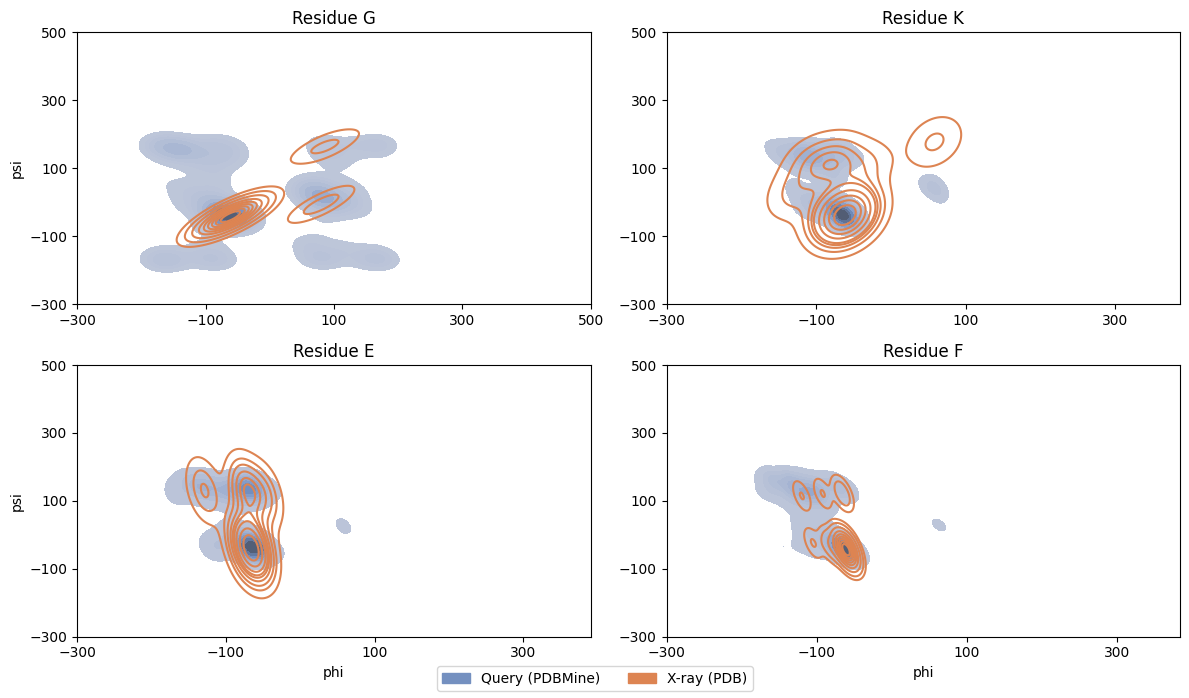

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot PDB

fig, axes = plt.subplots(2,2,figsize=(12,7))

m=0
for i,key in enumerate(phi_psi_mined.res.unique()[m:m+4]):
    ax = axes.flatten()[i]
    # alphafold: T1024TS427_1	
    phi_psi_alpha = phi_psi_predictions[(phi_psi_predictions.res == key) & (phi_psi_predictions.protein_id == 'T1024TS427_1')]
    phi_psi_dist = phi_psi_mined_filtered[phi_psi_mined_filtered.res == key]
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
    sns.kdeplot(data=phi_psi_alpha, x='phi', y='psi', ax=ax, fill=False, zorder=10, color='#dd8452', legend=True)

    ax.set_title(f'Residue {key}')
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yticks(ax.get_yticks()[::2])
    ax.set_xlabel('phi' if i > 1 else '')
    ax.set_ylabel('psi' if i % 2 == 0 else '')


# legend on bottom middle
patch1 = mpatches.Patch(color='#7490c0', label='Query (PDBMine)')
patch2 = mpatches.Patch(color='#dd8452', label='X-ray (PDB)')
fig.legend(handles=[patch1, patch2], loc='lower center', ncol=2)
# fig.suptitle(f'Distribution of phi, psi angles for the residues in {protein_id_pdb}')
plt.tight_layout()

In [17]:
def get_mahalanobis_dist(x, dist):
    # x should be 1 x n_features
    # dist should be n_obs x n_features
    icov = np.linalg.inv(np.cov(dist.T))
    md = (x - dist.mean(axis=0)) @ icov @ (x - dist.mean(axis=0))
    if md < 0:
        print(x, dist.mean(axis=0), icov)
    return np.sqrt(md)

def get_maha_for_row(dist_df, row):
    res = row['res']
    if row.name % 100000 == 0:
        print(row.name)
    if res == 'X':
        return np.nan
    phi_psi = dist_df.loc[dist_df.res == res, ['phi','psi']].dropna().values
    return get_mahalanobis_dist(row[['phi','psi']].values, phi_psi)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    phi_psi_predictions['mahalanobis_dist'] = phi_psi_predictions.apply(lambda x: get_maha_for_row(phi_psi_mined_filtered, x), axis=1)

0
100000


In [8]:
# phi_psi_predictions.to_csv('phi_psi_predictions_mahalanobis.csv', index=False)
phi_psi_predictions = pd.read_csv('phi_psi_predictions_maha.csv')

In [17]:
list(filter(lambda x: 'RMS' in x, list(results.columns)))

['RMS_CA', 'RMS_ALL', 'RMSD[L]', 'RMSD[D]']

In [30]:
phi_psi_predictions.groupby(['protein_id', 'res'], as_index=False).mean(numeric_only=True)

,protein_id,res,phi,psi,idx_in_seq,pos_in_chain,mahalanobis_dist
0,T1024TS004_1,A,-70.930605,-16.731000,2.102564,189.641026,0.821628
1,T1024TS004_1,C,-62.098950,-48.468993,4.000000,270.000000,1.085924
2,T1024TS004_1,D,-79.231050,2.415932,2.222222,179.888889,0.863797
3,T1024TS004_1,E,-72.937816,20.973139,2.200000,220.700000,1.059299
4,T1024TS004_1,F,-68.806628,-15.142412,2.121212,172.666667,0.938775
...,...,...,...,...,...,...,...
9675,T1024TS498_5,S,-64.370276,-23.840503,2.045455,204.181818,0.978931
9676,T1024TS498_5,T,-70.766463,-22.178436,2.343750,221.625000,1.231955
9677,T1024TS498_5,V,-59.314268,-36.669519,2.272727,223.424242,1.372180
9678,T1024TS498_5,W,-46.879966,-4.390560,2.428571,177.714286,1.206592


In [38]:
phi_psi_predictions.groupby(['res', 'protein_id'], as_index=False).mean(numeric_only=True).sort_values('mahalanobis_dist').set_index('protein_id')

,res,phi,psi,idx_in_seq,pos_in_chain,mahalanobis_dist
protein_id,,,,,,
T1024TS140_2,C,-82.603340,-7.580812,4.0,270.0,0.395766
T1024TS081_4,C,-82.914400,-16.933089,4.0,270.0,0.452270
T1024TS129_1,C,-81.077691,-19.333285,4.0,270.0,0.490198
T1024TS131_2,C,-80.288649,-18.435257,4.0,270.0,0.492694
T1024TS226_1,C,-81.122951,-19.842425,4.0,270.0,0.495388
...,...,...,...,...,...,...
T1024TS376_2,C,NaN,-22.947072,4.0,270.0,NaN
T1024TS376_5,C,-78.624137,NaN,4.0,270.0,NaN
T1024TS448_1,C,NaN,-34.386912,4.0,270.0,NaN


(0.0, 6.0)

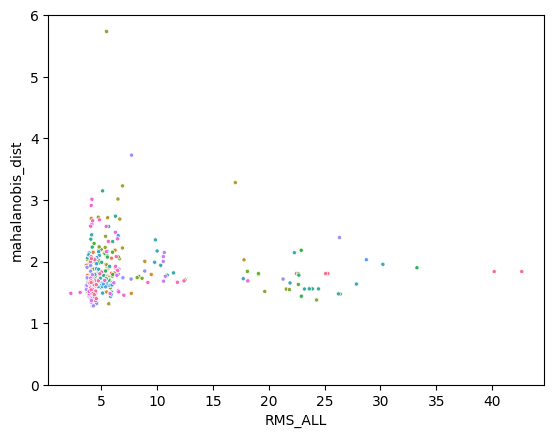

In [46]:
# mean_maha
import matplotlib.pyplot as plt
group_maha = phi_psi_predictions.groupby(['res', 'protein_id'], as_index=False).mean(numeric_only=True).sort_values('mahalanobis_dist').set_index('protein_id')
group_maha = group_maha.join(results.set_index('Model')[['RMS_ALL']], how='right')
group_maha = group_maha.groupby('protein_id').max()
fig, ax = plt.subplots()
sns.scatterplot(data=group_maha, x='RMS_ALL', y='mahalanobis_dist', ax=ax, marker='.', hue='protein_id', legend=False)
# ax.set_xlim((0.8,1.4))
ax.set_ylim((0,6))

# Results - By Window

In [112]:
phi_psi_mined_by_window = pd.read_csv('phi_psi_mined_by_window.csv')
phi_psi_predictions_by_window = pd.read_csv('phi_psi_predictions_by_window.csv')
phi_psi_mined_by_window['source'] = 'Query (PDBMine)'
phi_psi_predictions_by_window['source'] = 'Prediction'

In [47]:
for record in SeqIO.parse(xray_fn, "pdb-seqres"):
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    print(record)
residue_chain = str(record.seq)

Record id 6T1Z:A, chain A
ID: 6T1Z:A
Name: 6T1Z:A
Description: UNP:Q48658 Q48658_9LACT
Database cross-references: UNP:Q48658, UNP:Q48658_9LACT
Number of features: 0
/chain=A
/molecule_type=protein
Seq('GKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAV...FQG')


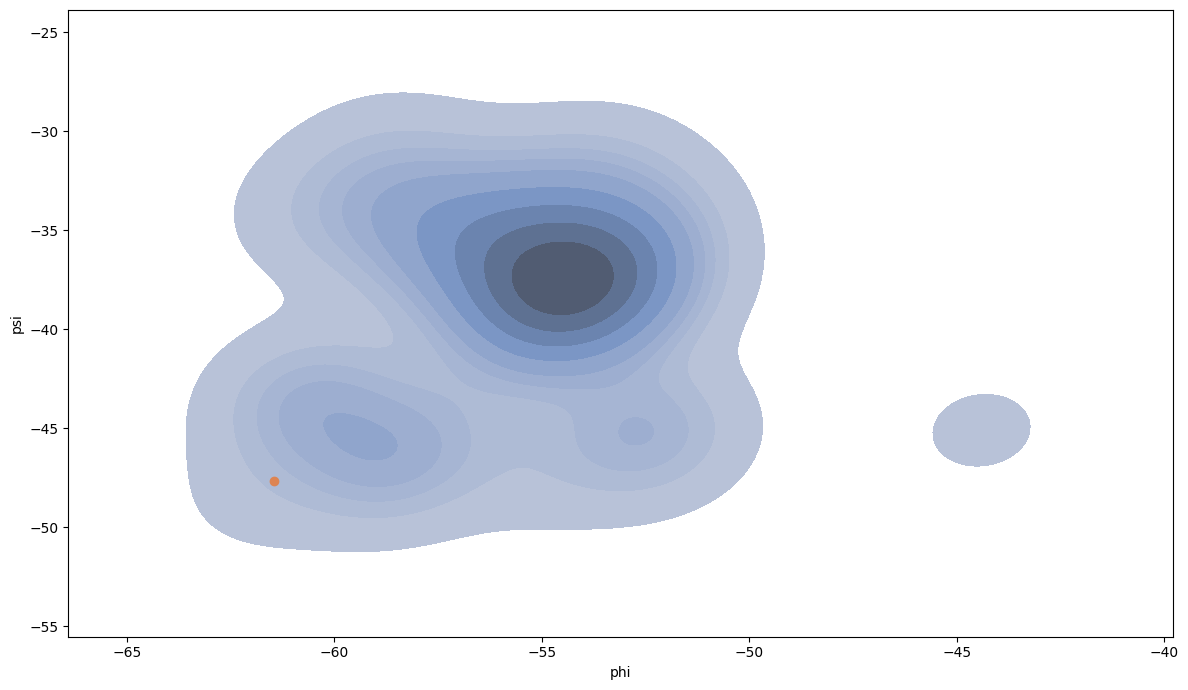

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, axes = plt.subplots(figsize=(12,7))

#     ax = axes.flatten()[i]
#     # alphafold: T1024TS427_1	
#     phi_psi_alpha = phi_psi_predictions[(phi_psi_predictions.res == key) & (phi_psi_predictions.protein_id == 'T1024TS427_1')]
#     phi_psi_dist = phi_psi_mined_filtered[phi_psi_mined_filtered.res == key]
#     sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
#     sns.kdeplot(data=phi_psi_alpha, x='phi', y='psi', ax=ax, fill=False, zorder=10, color='#dd8452', legend=True)

#     ax.set_title(f'Residue {key}')
#     ax.set_xticks(ax.get_xticks()[::2])
#     ax.set_yticks(ax.get_yticks()[::2])
#     ax.set_xlabel('phi' if i > 1 else '')
#     ax.set_ylabel('psi' if i % 2 == 0 else '')

seq = phi_psi_mined_by_window.seq.unique()[1]
phi_psi_dist = phi_psi_mined_by_window[phi_psi_mined_by_window.seq == seq]
phi_psi_alpha = phi_psi_predictions_by_window[(phi_psi_predictions_by_window.protein_id == 'T1024TS427_1') & (phi_psi_predictions_by_window.seq == seq)]
sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=axes, fill=True, color='#7490c0', legend=True)
plt.plot(phi_psi_alpha.phi, phi_psi_alpha.psi, 'o', color='#dd8452', label='Prediction')

# # legend on bottom middle
# patch1 = mpatches.Patch(color='#7490c0', label='Query (PDBMine)')
# patch2 = mpatches.Patch(color='#dd8452', label='X-ray (PDB)')
# fig.legend(handles=[patch1, patch2], loc='lower center', ncol=2)
# fig.suptitle(f'Distribution of phi, psi angles for the residues in {protein_id_pdb}')
plt.tight_layout()

In [297]:
phi_psi_predictions_by_window['mahalanobis_dist'] = np.nan
for seq in phi_psi_mined_by_window.seq.unique():
    phi_psi = phi_psi_mined_by_window[phi_psi_mined_by_window.seq == seq][['phi','psi']].dropna().values
    if phi_psi.shape[0] < 2:
        continue
    cov = np.cov(phi_psi.T)
    if np.linalg.det(cov) == 0:
        continue
    icov = np.linalg.inv(cov)
    preds = phi_psi_predictions_by_window.loc[phi_psi_predictions_by_window.seq == seq][['phi','psi']].values
    icov = np.repeat(np.expand_dims(icov, 0), preds.shape[0], axis=0) # expand for batch matrix multiplication
    md = (np.expand_dims((preds - phi_psi.mean(axis=0)), 1) @ icov @ np.expand_dims((preds - phi_psi.mean(axis=0)), 2)).squeeze()
    if np.any(md < 0):
        continue
    md = np.sqrt(md)
    phi_psi_predictions_by_window.loc[phi_psi_predictions_by_window.seq == seq, 'mahalanobis_dist'] = md

In [313]:
phi_psi_predictions_by_window.to_csv('phi_psi_predictions_by_window_maha.csv', index=False)

In [345]:
group_maha

,protein_id,phi,psi,mahalanobis_dist,Model,RMS_ALL
0,T1024TS004_1,-28190.444943,-3252.197094,8.484913e+09,T1024TS004_1,25.296
1,T1024TS004_2,-28146.523142,-3234.629680,8.488801e+09,T1024TS004_2,22.468
2,T1024TS004_3,-28152.504328,-3301.725501,8.493832e+09,T1024TS004_3,25.095
3,T1024TS004_4,-28150.105770,-3455.868714,8.487125e+09,T1024TS004_4,42.649
4,T1024TS004_5,-28107.101504,-3439.023820,8.484714e+09,T1024TS004_5,40.184
...,...,...,...,...,...,...
479,T1024TS498_1,-27303.409984,-10426.315166,1.483601e+10,T1024TS498_1,4.560
480,T1024TS498_2,-26693.264252,-9990.391627,1.423974e+10,T1024TS498_2,4.074
481,T1024TS498_3,-26061.115368,-9936.279381,1.397413e+10,T1024TS498_3,4.083
482,T1024TS498_4,-25750.823561,-10621.087916,1.401125e+10,T1024TS498_4,4.094


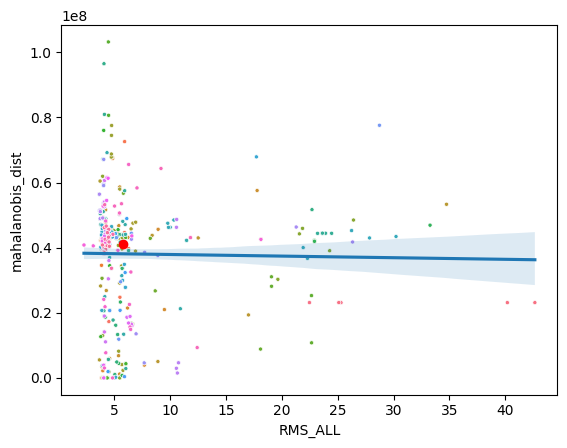

In [348]:
# Compare rmsd and mahalanobis distance
import matplotlib.pyplot as plt
group_maha = phi_psi_predictions_by_window.groupby(['protein_id'], as_index=False).mean(numeric_only=True)#.sort_values('mahalanobis_dist').set_index('protein_id').dropna()
group_maha = group_maha.merge(results[['Model', 'RMS_ALL']], left_on='protein_id', right_on='Model', how='inner')
group_maha
fig, ax = plt.subplots()
sns.scatterplot(data=group_maha, x='RMS_ALL', y='mahalanobis_dist', ax=ax, marker='.', hue='protein_id', legend=False)
sns.regplot(data=group_maha, x='RMS_ALL', y='mahalanobis_dist', ax=ax, scatter=False)
plt.plot(group_maha[group_maha.protein_id == 'T1024TS427_1']['RMS_ALL'], group_maha[group_maha.protein_id == 'T1024TS427_1']['mahalanobis_dist'], 'o', color='red', label='Alphafold')
# # ax.set_xlim((0.8,1.4))
# ax.set_ylim((0,6))

(2, 7)
(8, 7)
(5, 7)
(8, 7)


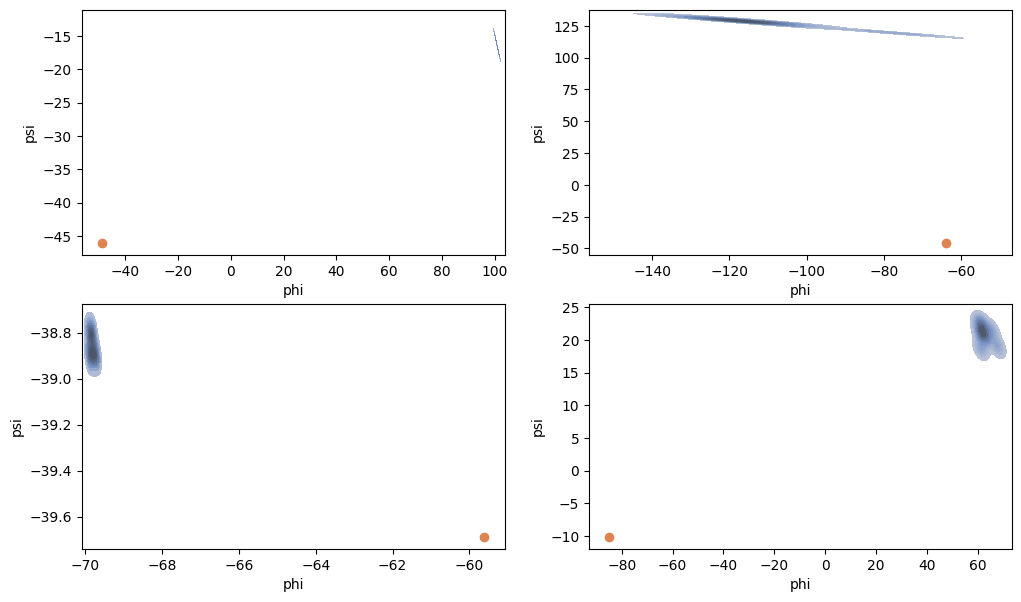

In [362]:
# plot dists with highest mahalanobis distance for alphafold
phi_psi_alpha = phi_psi_predictions_by_window[phi_psi_predictions_by_window.protein_id == 'T1024TS427_1']
seqs_with_highest_maha = phi_psi_alpha.sort_values('mahalanobis_dist', ascending=False).head(16).seq.values

m = 0
fig, axes = plt.subplots(2,2,figsize=(12,7))
for i,seq in enumerate(seqs_with_highest_maha[m:m+4]):
    phi_psi_dist = phi_psi_mined_by_window[phi_psi_mined_by_window.seq == seq]
    print(phi_psi_dist.shape)
    phi_psi_alpha_seq = phi_psi_alpha[phi_psi_alpha.seq == seq]
    ax = axes.flatten()[i]
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
    ax.plot(phi_psi_alpha_seq.phi, phi_psi_alpha_seq.psi, 'o', color='#dd8452', label='Prediction')
